# Visualisation of correlation method

This notebook is not for analyzing the data but only to create an example plot to be used in the methods section. The plot aims to show how single volumes correlate with the templates and how these correlations can be transformed into decisions.  

While the data used for this example plot are real, they are not independent (the target patient has not been left out of the group plots) and have been selected by hand.

### import modules

In [2]:
import pickle

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from nilearn import input_data, plotting, image
from tqdm import tqdm

from surfer import Brain, Surface, project_volume_data
from mayavi import mlab
mlab.init_notebook()

Notebook initialized with x3d backend.


### global variables  

Hack: individual volumes are stored temporarily and re-loaded, in order to combine into large image.

In [2]:
temp_nii = '../temp/temp.nii.gz'
temp_png = '../temp/temp.png'

### define colors for plotting
Color scheme is taken from Byrne’s Euclid (https://www.c82.net/euclid/)
![alt](https://www.c82.net/images/euclid/book1.png)

#### scraped color scheme

In [3]:
# colors taken from css of https://www.c82.net/euclid/
d = {
    "black": "#000000",
    "blue": "#0e638e",
    "red": "#d42a20",
    "trans": "#fcf3d9",
    "white": "#ffffff",
    "yellow": "#fac22b"
}

#### transformation into RGB/255

In [4]:
def hex_to_rgb(my_hex):
    """transfrom hex values to rgb/255 values
    code adapted from John1024, https://stackoverflow.com/a/29643643
    """
    h = my_hex.lstrip('#')
    rgb = tuple(int(h[i:i + 2], 16) / 255 for i in (0, 2, 4))
    return rgb

In [5]:
# transfrom  hex to rgb, collect in dict
color_dict = {}
for k in d:
    my_hex = d[k]
    my_rgb = hex_to_rgb(my_hex)
    color_dict[k] = my_rgb

color_dict

{'black': (0.0, 0.0, 0.0),
 'blue': (0.054901960784313725, 0.38823529411764707, 0.5568627450980392),
 'red': (0.8313725490196079, 0.16470588235294117, 0.12549019607843137),
 'trans': (0.9882352941176471, 0.9529411764705882, 0.8509803921568627),
 'white': (1.0, 1.0, 1.0),
 'yellow': (0.9803921568627451, 0.7607843137254902, 0.16862745098039217)}

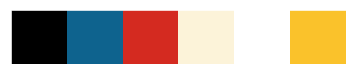

In [6]:
sns.palplot([color_dict[c] for c in color_dict])

In [7]:
with open('../models/colors.p', 'wb') as f:
    pickle.dump(color_dict, f)

In [8]:
#### selection of main colors  
my_cols = {}
for i, j in zip(['red', 'blue', 'yellow'], ['left', 'right', 'bilateral']):
    my_cols[j] = color_dict[i]

my_cols

{'left': (0.8313725490196079, 0.16470588235294117, 0.12549019607843137),
 'right': (0.054901960784313725, 0.38823529411764707, 0.5568627450980392),
 'bilateral': (0.9803921568627451, 0.7607843137254902, 0.16862745098039217)}

### reg file, to get volumes onto the surface  

Taken from freesurfer/average/mni152.register.dat

In [9]:
reg_file = "../data/external/mni152.register.dat"

### template data

In [10]:
template_im = image.index_img('../helper/laterality_index_deconstruction/models/tMap_diff_left.nii.gz',-1)

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


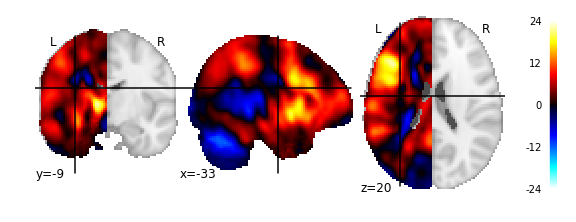

In [11]:
plotting.plot_stat_map(template_im)

get only positive values

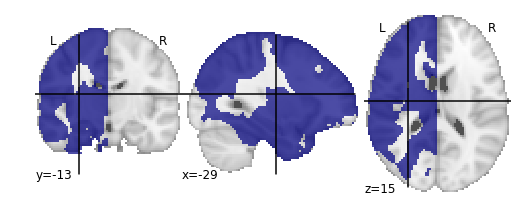

In [12]:
whole_brain_masker = input_data.NiftiMasker('../data/external/MNI152_T1_2mm_brain_mask.nii.gz').fit()
data = whole_brain_masker.transform(template_im)
my_data = data>0
template_mask = whole_brain_masker.inverse_transform(my_data)
masker = input_data.NiftiMasker(template_mask).fit()

plotting.plot_roi(masker.mask_img_);

In [13]:
template_im = image.math_img('img1*img2',img1=template_im,img2=masker.mask_img_)

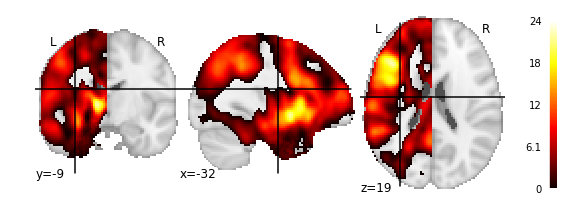

In [14]:
plotting.plot_stat_map(template_im,threshold=0);

### template data

In [15]:
template_data = masker.transform(template_im)

In [16]:
template_data

array([[3.445243 , 3.6140587, 3.326242 , ..., 3.8114498, 3.7049038,
        3.5861745]], dtype=float32)

### example data

In [17]:
example_file = '../../wortStudie/p010/data/wrrun001.nii'

In [18]:
import nibabel as nib
from sklearn import preprocessing

In [19]:
def make_flip(fileName):
    """get an image and flip it along the x-axis (i.e. L-R flip)"""

    # load the image file
    img = nib.load(fileName)
    # get image and header
    image_data, image_affine = img.get_data(), img.affine
    # make L-R flip
    flip_img = nib.Nifti1Image(image_data[::-1], image_affine)

    return flip_img

In [20]:
example_data = masker.transform(example_file)
example_data = preprocessing.scale(example_data,axis=0)
orig_im = masker.inverse_transform(example_data)
orig_im = image.smooth_img(orig_im,6)
orig_name = '../temp/example.nii.gz'
orig_im.to_filename(orig_name)

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [21]:
flip_im = make_flip(orig_name)
diff_im = image.math_img('img1-img2',img1=orig_im,img2=flip_im)

In [22]:
diff_data = masker.transform(diff_im)

In [23]:
scaled_data = preprocessing.scale(diff_data,axis=1)

In [24]:
vol_im = masker.inverse_transform(scaled_data[2])

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


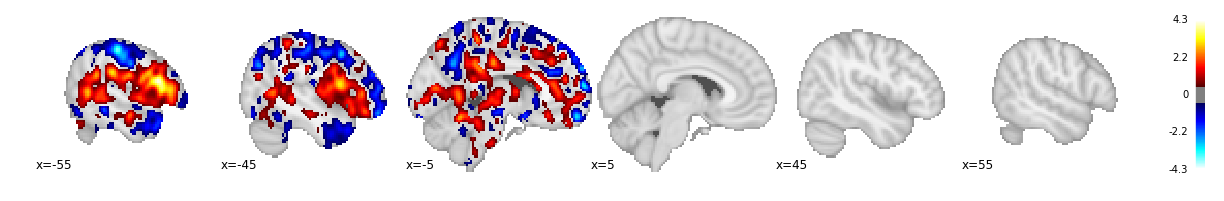

In [25]:
plotting.plot_stat_map(vol_im,threshold=0.5,display_mode='x',cut_coords=(-55, -45, -5, 5, 45, 55));

### plotting using pysurfer

In [26]:
def make_one_plot(vol_im,my_min=0.5,my_max=3,temp_nii=temp_nii,temp_png=temp_png):
    '''collect one volume, project on surface and make nice image which is saved as a temporary file'''
    
    # save as file
    vol_im.to_filename(temp_nii)
    
    # transform volume nii to surface array
    surf_data = project_volume_data(temp_nii,'lh', reg_file, smooth_fwhm=0)
    
    # use fsaverage for projection on surface
    b = Brain('fsaverage', 'lh', 'inflated',background='white',size=1000)
    # add data to surface
    b.add_overlay(surf_data, min=my_min, max=my_max, hemi='lh')
    # no colorbar
    b.hide_colorbar()
    # view the left hemisphere laterally
    lh_view_settings = dict(azimuth=180, elevation=90,focalpoint=[0,0,0])
    b.show_view(lh_view_settings)
    
    # hide the axes
    plt.yticks([])
    plt.xticks([])
    # show the resulting image
    plt.imshow( b.screenshot() )
    
    # save image
    plt.tight_layout()
    plt.savefig(temp_png,bbox_inches='tight',dpi=300)
    plt.close()
    
    return temp_png

### example

In [27]:
temp_png = make_one_plot(vol_im,my_min=0.5)

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s60nf2j52.mgz


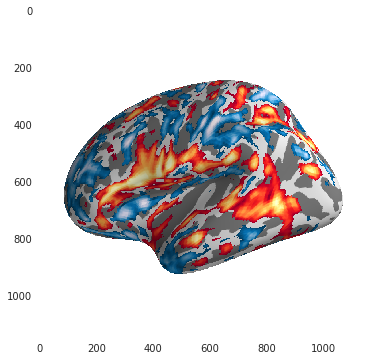

In [28]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.imshow(Image.open(temp_png))
plt.show()

### generate and store template images

In [29]:
template_max = image.load_img(template_im).get_data().max()
template_png = make_one_plot(image.load_img(template_im),
                             my_min=0.5,
                             my_max=template_max,
                             temp_png='../temp/template.png'
                            )

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2slygn4248.mgz


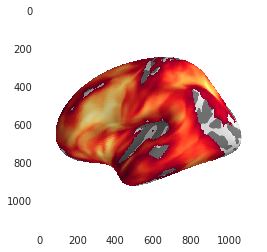

In [30]:
plt.imshow(Image.open(template_png));

### make white into transparency to allow images to overlap

In [31]:
def make_transparent(temp_png=temp_png):
    '''turn white pixel into transparent pixel'''
    
    # load png file and convert to a format that allows for transparency
    img=Image.open(temp_png)
    img = img.convert("RGBA")
    
    # get rgba values
    datas = img.getdata()

    # if a pixel is white (the first three entries are 255)
    # then make it transparent (last value (the alpha) is zero)
    new_data = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            new_data.append((255, 255, 255, 0))
        else:
            new_data.append(item)

    # make new image
    img.putdata(new_data)
    
    return img

In [32]:
trans_img = make_transparent(temp_png)

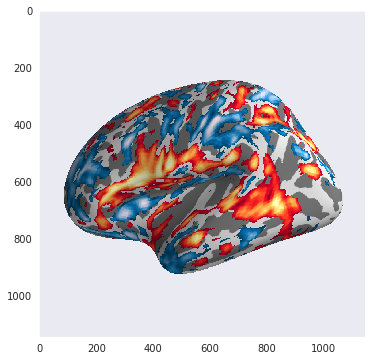

In [33]:
plt.figure(figsize=(10,6))
plt.imshow(trans_img)
plt.show()

### define range of volumes to be used

In [34]:
start = 52
vol_nums = range(start,start+10)

### compute correlations of volumes with templates

In [35]:
corrs = [np.corrcoef(scaled_data[x],template_data)[1][0]  for x in vol_nums]

In [36]:
corrs

[0.073139923575102,
 0.11509895487445854,
 -0.09136823752451707,
 -0.1625749261748367,
 0.04392165162880436,
 0.18645296319840762,
 0.1880116037666767,
 -0.012809834524953169,
 -0.3169830686526392,
 -0.019395572001094215]

### plot with all correlations

In [37]:
my_cut = 0.05

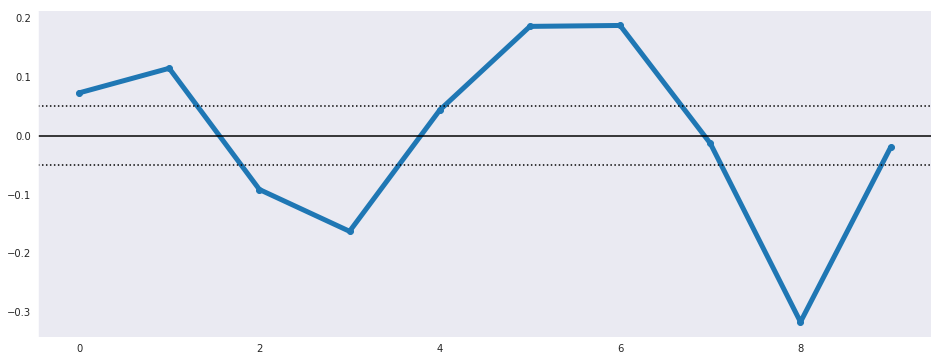

In [38]:
plt.figure(figsize=(16,6))
plt.plot(corrs,'-o',linewidth=5)
plt.axhline(0,color='k')
plt.axhline(-my_cut,color='k',linestyle=':')
plt.axhline(my_cut,color='k',linestyle=':')
sns.despine()
plt.show()

### make composite image

In [39]:
sns.set_style('dark')

In [40]:
def make_series_plot(more_data,vol_nums,my_min=0,my_max=2,distance=500):
    '''takes a series of volumes, makes RGBA images and overlays them onto each other'''

    #creates a new empty image, RGB mode with transparency (alpha)
    series_im = Image.new('RGBA', (5700,1000), (255, 0, 0, 0))

    for i, idx in enumerate(tqdm(vol_nums)):
        # grab one volume
        vol_im = masker.inverse_transform(more_data[idx])
        # make image
        temp_png = make_one_plot(vol_im,my_min=my_min,my_max=my_max)
        # make white transparent
        trans_img = make_transparent(temp_png)
        # add to big image, with slight overlap
        series_im.paste(trans_img, (i*distance,0),mask=trans_img)
        
    return series_im

In [41]:
series_im = make_series_plot(scaled_data,vol_nums,my_min=0.5,my_max=3,distance=500)

  0%|          | 0/10 [00:00<?, ?it/s]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2smxc4_a1z.mgz


 10%|█         | 1/10 [00:09<01:21,  9.02s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s1_6zq6fj.mgz


 20%|██        | 2/10 [00:17<01:10,  8.83s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s520gpjb4.mgz


 30%|███       | 3/10 [00:24<00:58,  8.43s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sjw1zgq2e.mgz


 40%|████      | 4/10 [00:33<00:50,  8.41s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s_vilf9ot.mgz


 50%|█████     | 5/10 [00:42<00:42,  8.54s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2srd1btd9x.mgz


 60%|██████    | 6/10 [00:50<00:33,  8.41s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s8a2m6846.mgz


 70%|███████   | 7/10 [00:58<00:25,  8.50s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sf2onx2xw.mgz


 80%|████████  | 8/10 [01:07<00:17,  8.50s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2so63fftcn.mgz


 90%|█████████ | 9/10 [01:15<00:08,  8.43s/it]

mri_vol2surf --mov /data/martin/volume-wise-language/temp/temp.nii.gz --hemi lh --surf white --reg ../data/external/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2snurt6tet.mgz


100%|██████████| 10/10 [01:23<00:00,  8.39s/it]


In [42]:
sns.set_style('white')

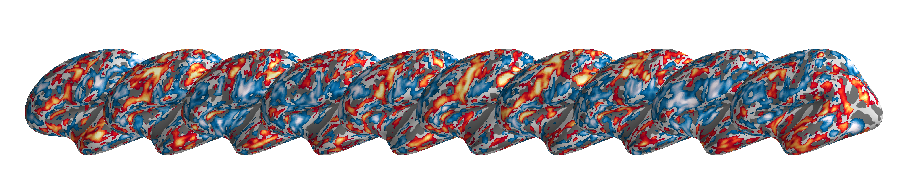

In [43]:
fig, ax = plt.subplots(1,1,figsize=(16,6))

ax.imshow(series_im)
ax.set_xticks([])
ax.set_yticks([])

sns.despine(left=True,bottom=True)
plt.show()

In [44]:
corr_df = pd.DataFrame(corrs)
corr_df.columns = ['corr']
for i in corr_df.index:
    this_corr = corr_df.loc[i,'corr']
    if abs(this_corr)<my_cut:
        corr_df.loc[i,'pred'] = 'B'
    elif this_corr>my_cut:
        corr_df.loc[i,'pred'] = 'L'
    else:
        corr_df.loc[i,'pred'] = 'R'

In [45]:
corr_df

corr pred
0  0.073140    L
1  0.115099    L
2 -0.091368    R
3 -0.162575    R
4  0.043922    B
5  0.186453    L
6  0.188012    L
7 -0.012810    B
8 -0.316983    R
9 -0.019396    B

## Make big plot

### function to draw colored rectangles around individual subplots

In [46]:
# adapted from https://stackoverflow.com/questions/2027592/draw-a-border-around-subplots-in-matplotlib/2028743#2028743
def add_rec(ax,col,wid=9):
    '''add color border around a subplot'''
    
    autoAxis = ax.axis()
    rec = plt.Rectangle((autoAxis[0] - 0.7, autoAxis[2] - 0.2),
                        (autoAxis[1] - autoAxis[0]) + 1,
                        (autoAxis[3] - autoAxis[2]) + 0.4,
                        fill=False,
                        lw=wid)
    rec = ax.add_patch(rec)
    rec.set_color(col)
    rec.set_clip_on(False)
    return

### toy example to figure out precise placing of subplots

In [47]:
#fig = plt.figure(figsize=(16, 6))
#ax1 = fig.add_axes([0.45, 1, 1.55, 1], xticklabels=[], yticklabels=[]);ax1.set_title(1,fontsize=100,y=0.5)
#ax2 = fig.add_axes([0, 1.0, 0.4, 0.6], xticklabels=[], yticklabels=[]);ax2.set_title(2,fontsize=100,y=0.5)
#ax3 = fig.add_axes([0, 0.2, 0.4, 0.6], xticklabels=[], yticklabels=[]);ax3.set_title(3,fontsize=100,y=0.5)
#ax4 = fig.add_axes([0.45, 0.2, 1.55, 0.9], xticklabels=[], yticklabels=[]);ax4.set_title(4,fontsize=100,y=0.5)
#ax5 = fig.add_axes([0.45, -0.3, 1.55, 0.2], xticklabels=[], yticklabels=[]);ax5.set_title(5,fontsize=100,y=0.5)
#plt.show()

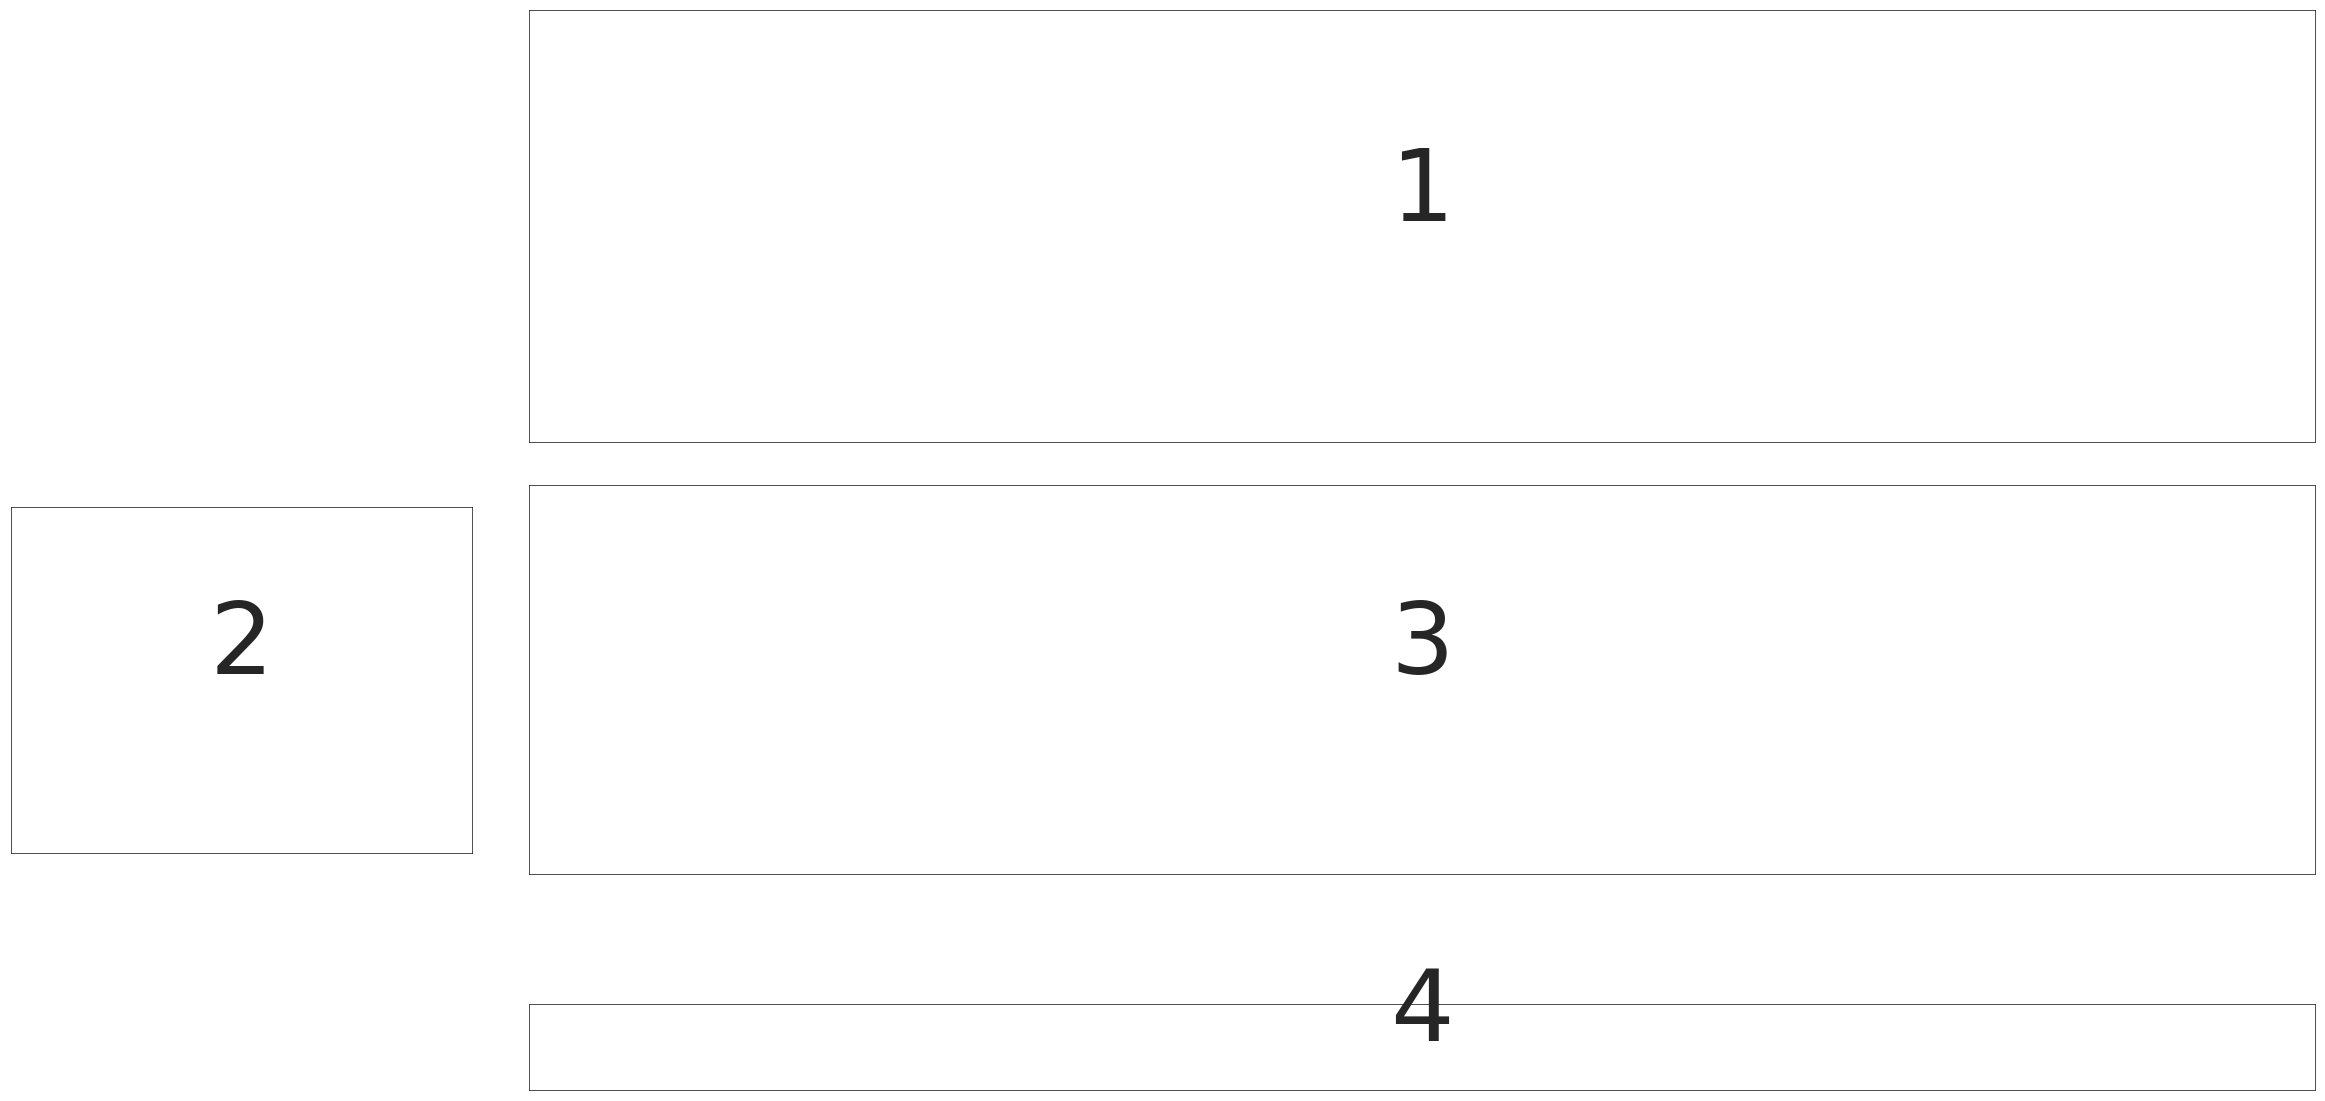

In [48]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_axes([0.45, 1.3, 1.55, 1], xticklabels=[], yticklabels=[]);ax1.set_title(1,fontsize=100,y=0.5)

ax2 = fig.add_axes([0, 0.35, 0.4, 0.8], xticklabels=[], yticklabels=[]);ax2.set_title(2,fontsize=100,y=0.5)

ax3 = fig.add_axes([0.45, 0.3, 1.55, 0.9], xticklabels=[], yticklabels=[]);ax3.set_title(3,fontsize=100,y=0.5)
ax4 = fig.add_axes([0.45, -0.2, 1.55, 0.2], xticklabels=[], yticklabels=[]);ax4.set_title(4,fontsize=100,y=0.5)
plt.show()

### the big plot

In [49]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_axes([0.45, 1.2, 1.55, 1], xticklabels=[], yticklabels=[])
ax1.set_title("individual patient's volume-wise data", fontsize=48,y=.9)
ax1.imshow(series_im)
ax1.axis('off')

ax2 = fig.add_axes([0, 0.35, 0.4, 0.8], xticklabels=[], yticklabels=[])
ax2.imshow(Image.open(template_png))
ax2.set_title('Template', fontsize=48,y=.85)
#add_rec(ax2, 'k')

ax2.axis('off')

ax3 = fig.add_axes([0.45, 0.3, 1.55, 0.9], xticklabels=[], yticklabels=[])

ax3.fill_between([0, 10], [-my_cut, -my_cut], [my_cut, my_cut],
                 color=color_dict['trans'],
                 alpha=1)

ax3.axhline(0,color='k',linestyle='--',linewidth=10)

x = np.linspace(1.2, 8.2, 10)
ax3.plot(x, corr_df.loc[:,'corr'], '-', c='k', linewidth=9, alpha=1)

col_dict = {'L':'left','B':'bilateral','R':'right'}

for x_pos,vol_num in zip(x, corr_df.index):
    vol_value = corr_df.loc[vol_num,'corr']
    this_pred = corr_df.loc[vol_num,'pred']
    plt.plot(x_pos,vol_value,
             'o',
             c=my_cols[col_dict[this_pred]],
             markersize=24)

my_min = corr_df.loc[:,'corr'].min()
my_max = corr_df.loc[:,'corr'].max()
ax3.set_ylim(my_min*1.5,my_max*1.1)

ax3.set_xlim(0.4, 9)
ax3.set_ylabel('correlation', fontsize=48, labelpad=20)
ax3.set_xlabel('volume', fontsize=58, labelpad=20)

for axis in ['bottom', 'left']:
    ax3.spines[axis].set_linewidth(8)
sns.despine(offset=10)
    
ax4 = fig.add_axes([0.45, -0.2, 1.55, 0.2], xticklabels=[], yticklabels=[])

for i,s in zip(np.linspace(0.085,0.9,10),corr_df.loc[:,'pred']):
    this_col = my_cols[col_dict[s]]
    ax4.annotate(s,xy=(i,0.1),fontsize=64,color=this_col)
ax4.set_xlabel('prediction', fontsize=58, labelpad=20)
sns.despine(left=False, bottom=False)

for axis in ['bottom', 'left']:
    ax4.spines[axis].set_linewidth(0)

plt.savefig('../reports/figures/08-methods-fig.png',dpi=300,bbox_inches='tight')
plt.close()

### re-load and view the saved image

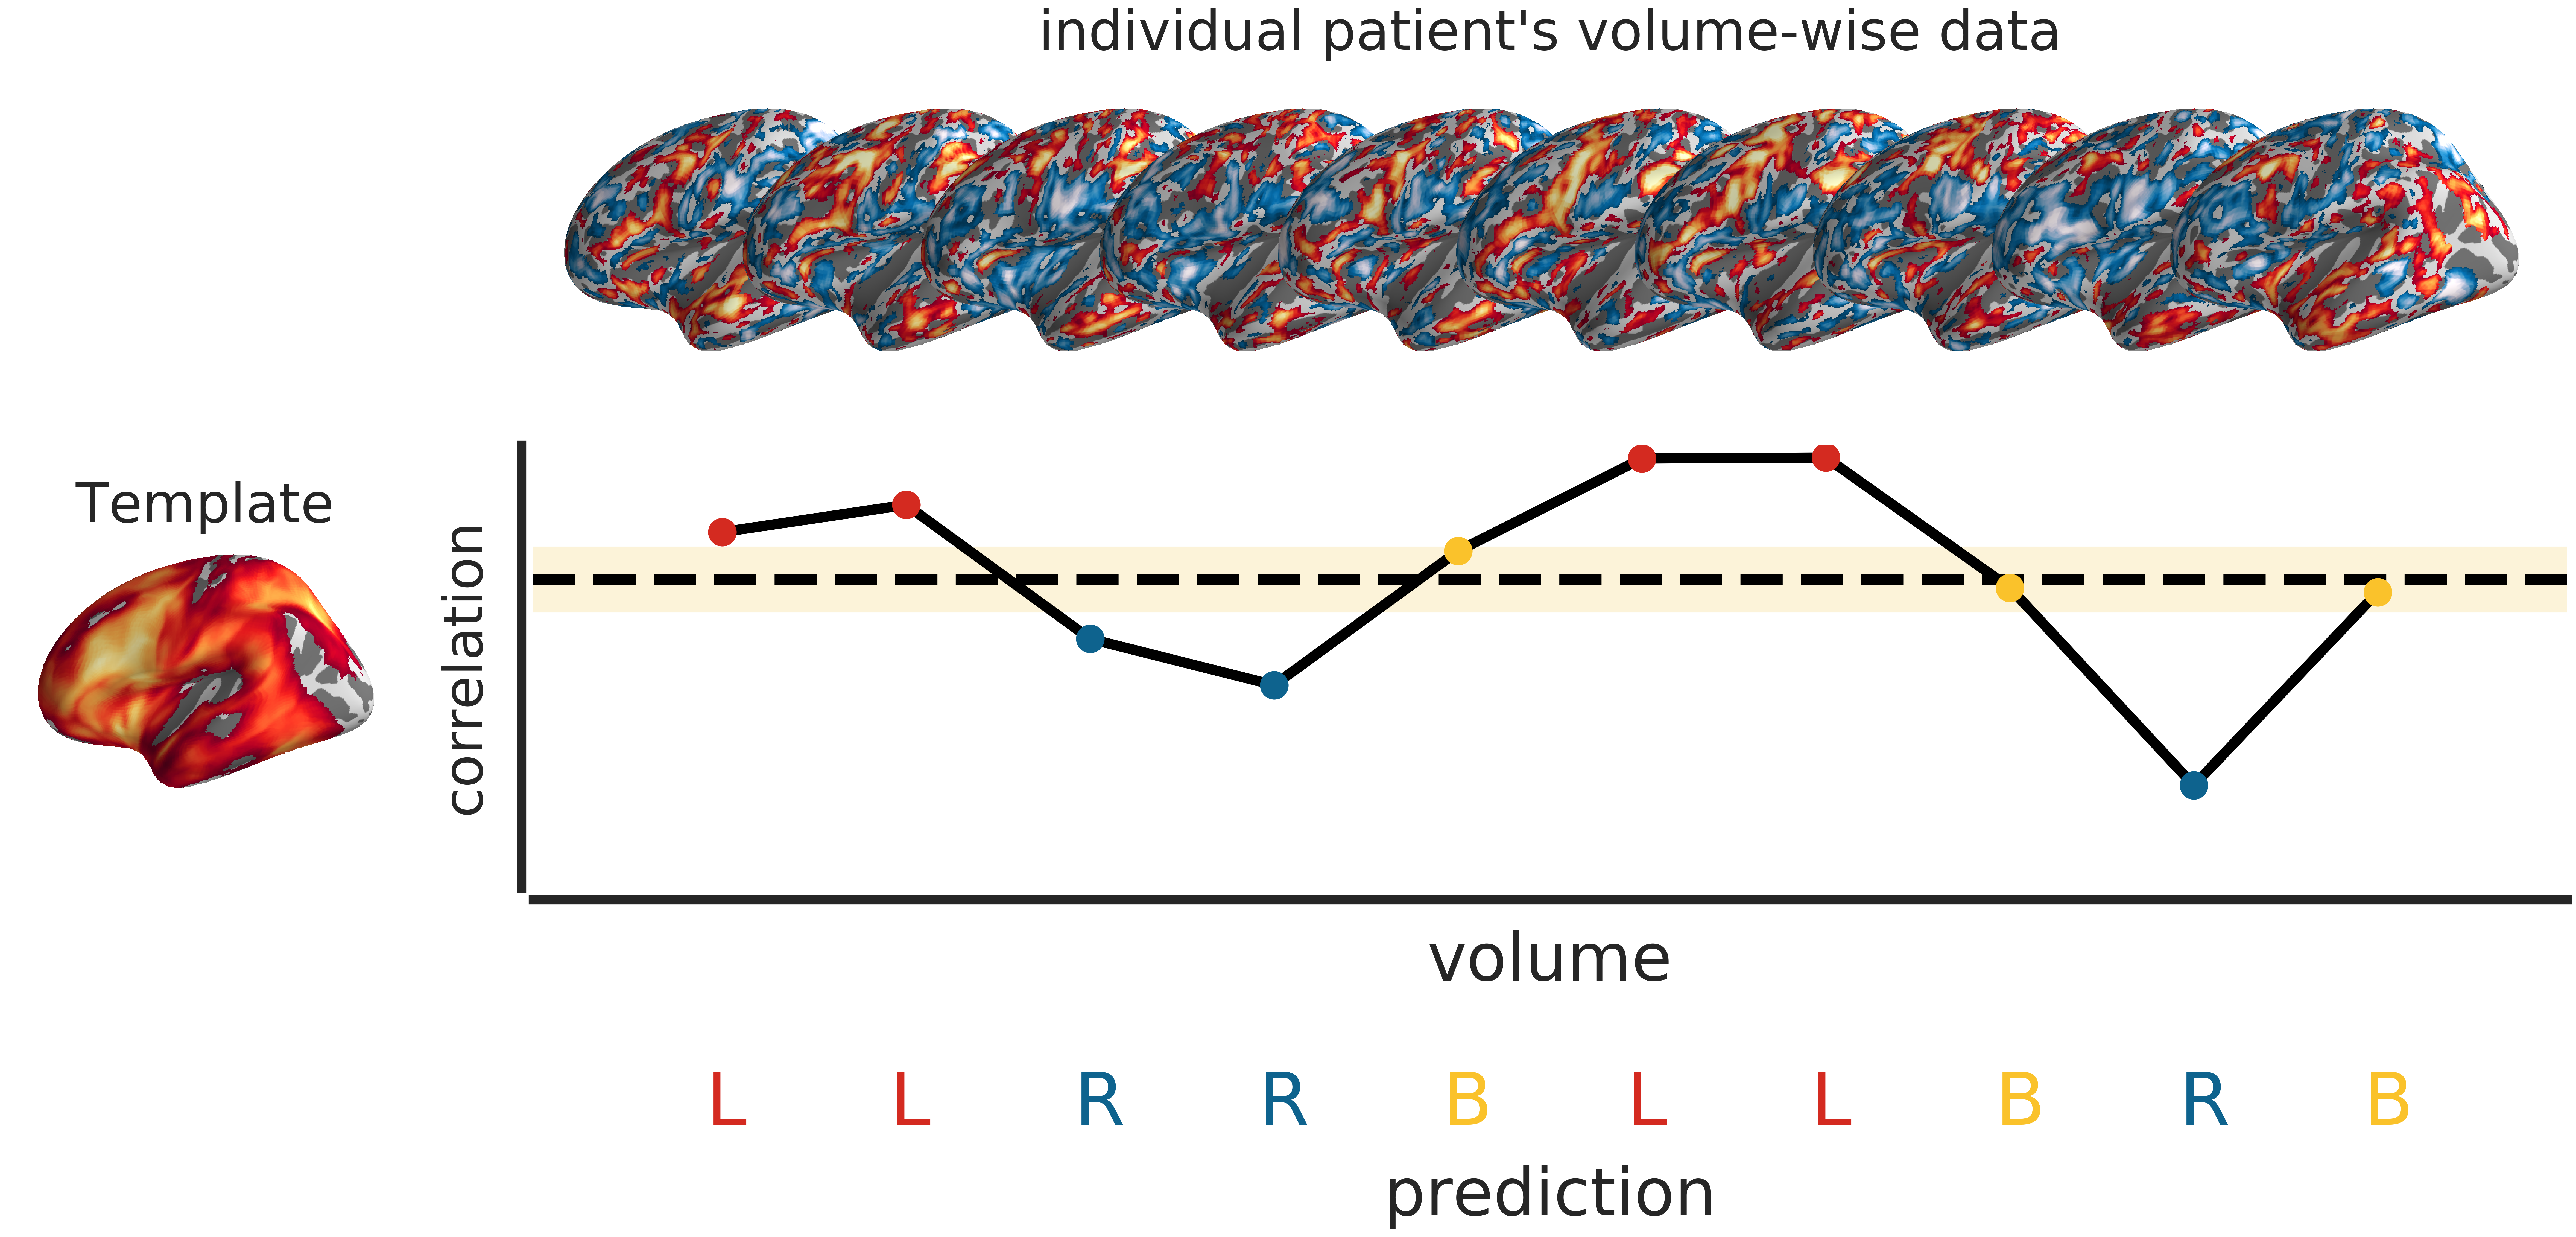

In [50]:
Image.open('../reports/figures/08-methods-fig.png')

### summary  

We see the target images with which we correlate on the left-hand side. We see a sample of 10 volumes of one patient on the upper right. We see the correlations of each of the ten volumes with the templates below that. And the highest correlation (i.e. the "winner") on the bottom right.
Hence, this plot illustrates the procedures we will employ in the following notebooks.


**************

< [Previous](07-mw-group-surface-plots.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](09-mw-correlations-with-template.ipynb)